In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

## Load the data

In [2]:
TRAIN_PATH = './Dataset/Beauty/Training'
VALID_PATH = './Dataset/Beauty/Validation'
TEST_PATH = './Dataset/Beauty/Testing'

In [3]:
IMG_SIZE = (96, 96)
BATCH_SIZE = 64

train_dataset = tf.keras.preprocessing.image_dataset_from_directory(TRAIN_PATH, shuffle=True, image_size=IMG_SIZE, batch_size = BATCH_SIZE)
valid_dataset = tf.keras.preprocessing.image_dataset_from_directory(VALID_PATH, shuffle=True, image_size=IMG_SIZE, batch_size = BATCH_SIZE)
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(TEST_PATH, shuffle=True, image_size=IMG_SIZE, batch_size = BATCH_SIZE)

Found 4000 files belonging to 2 classes.
Found 300 files belonging to 2 classes.
Found 300 files belonging to 2 classes.


In [4]:
print('Train batches:', tf.data.experimental.cardinality(train_dataset))
print('Test batches:', tf.data.experimental.cardinality(test_dataset))
print('Valid batches:', tf.data.experimental.cardinality(valid_dataset))

Train batches: tf.Tensor(63, shape=(), dtype=int64)
Test batches: tf.Tensor(5, shape=(), dtype=int64)
Valid batches: tf.Tensor(5, shape=(), dtype=int64)


In [4]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
valid_dataset = valid_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

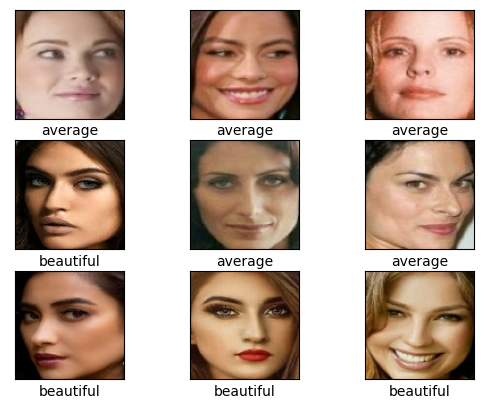

In [6]:
classes = ['average', 'beautiful']

for image, label in train_dataset.take(1):
  for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(image[i] / 255)
    plt.xticks([])
    plt.yticks([])
    plt.xlabel(classes[label[i]])

plt.show()

## Data agumentation

In [1]:
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomZoom, RandomRotation

data_augmentation = tf.keras.Sequential([
  RandomFlip('horizontal'),
  RandomRotation(0.05),
  RandomZoom(0.1)
])

NameError: name 'tf' is not defined

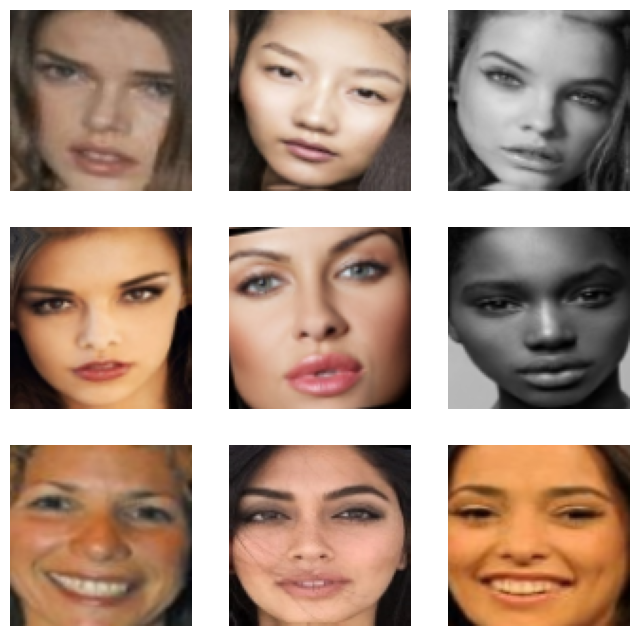

In [12]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(8, 8))
  for i in range(9):
    plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(image[i], 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

plt.show()

## Self-building model

In [13]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

model = tf.keras.Sequential([
  Input(shape=(IMG_SIZE + (3,))),

  data_augmentation,

  Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'),
  BatchNormalization(),
  MaxPooling2D(pool_size=2, strides=2),

  Conv2D(64, kernel_size=3, padding='same', activation='relu'),
  BatchNormalization(),
  MaxPooling2D(pool_size=2, strides=2),

  Conv2D(128, kernel_size=3, padding='same', activation='relu'),
  BatchNormalization(),
  MaxPooling2D(pool_size=2, strides=2),
  Dropout(0.2), 

  Conv2D(256, kernel_size=3, padding='same', activation='relu'),
  BatchNormalization(),
  MaxPooling2D(pool_size=2, strides=2),
  Dropout(0.2), 

  Flatten(),

  Dense(256, activation='relu'),
  Dropout(0.25),
  
  Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_2 (Sequential)    (None, 96, 96, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 96, 96, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 96, 96, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 48, 48, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 48, 48, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 48, 48, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 64)       

In [14]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
model.compile(optimizer=optimizer, loss=tf.keras.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [15]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, min_delta=1e-5, mode='auto', restore_best_weights=True, verbose=1)
checkpoint = tf.keras.callbacks.ModelCheckpoint('beauty_ckpt.h5', monitor='val_loss', save_weights_only=True)

history = model.fit(train_dataset, epochs=10, validation_data=valid_dataset, callbacks=[early_stopping, checkpoint])

Epoch 1/10
63/63 [==============================] - 9s 80ms/step - loss: 0.8226 - accuracy: 0.6616 - val_loss: 0.6398 - val_accuracy: 0.5433
Epoch 2/10
63/63 [==============================] - 3s 49ms/step - loss: 0.4875 - accuracy: 0.7739 - val_loss: 0.5225 - val_accuracy: 0.7067
Epoch 3/10
63/63 [==============================] - 3s 46ms/step - loss: 0.4663 - accuracy: 0.7780 - val_loss: 0.4533 - val_accuracy: 0.7933
Epoch 4/10
63/63 [==============================] - 4s 53ms/step - loss: 0.4341 - accuracy: 0.8054 - val_loss: 0.3520 - val_accuracy: 0.8500
Epoch 5/10
63/63 [==============================] - 4s 52ms/step - loss: 0.3824 - accuracy: 0.8290 - val_loss: 0.3140 - val_accuracy: 0.8833
Epoch 6/10
63/63 [==============================] - 3s 46ms/step - loss: 0.3838 - accuracy: 0.8165 - val_loss: 0.2990 - val_accuracy: 0.8833
Epoch 7/10
63/63 [==============================] - 3s 50ms/step - loss: 0.3665 - accuracy: 0.8392 - val_loss: 0.5155 - val_accuracy: 0.7933
Epoch 8/10
63

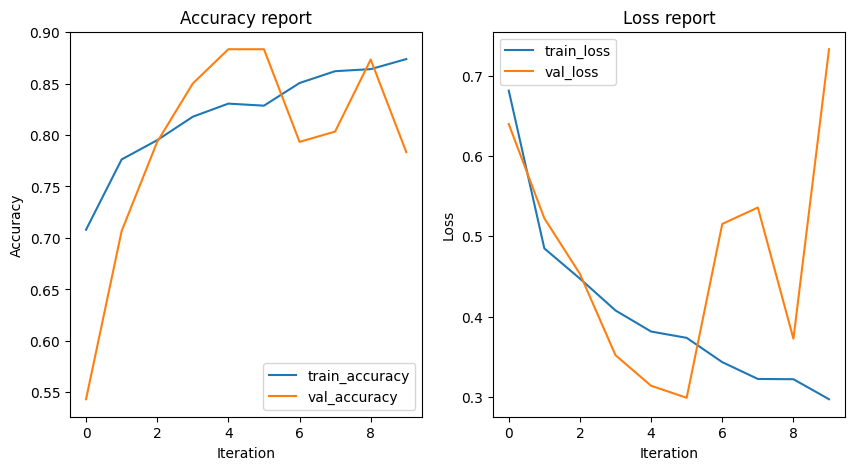

In [16]:
plt.figure(figsize=(10, 5))

plt.subplot(121)
plt.title('Accuracy report')
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.legend()


plt.subplot(122)
plt.title('Loss report')
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()


plt.show()

In [17]:
model.evaluate(test_dataset)

5/5 [==============================] - 0s 11ms/step - loss: 0.5856 - accuracy: 0.7933


[0.5855857729911804, 0.7933333516120911]

## Using pre-train model

### MobileNetV2

In [49]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

IMG_SHAPE = IMG_SIZE + (3,)

base_model = tf.keras.applications.MobileNetV2(input_shape=(IMG_SHAPE), include_top=False, weights='imagenet')

base_model.trainable = False

In [50]:
from tensorflow.keras.layers import Input, Dropout, Dense, GlobalAveragePooling2D

base_model.trainable = False

inputs = Input(shape=IMG_SHAPE)
preprocessed = preprocess_input(inputs)
features = base_model(preprocessed, training=False)
features = GlobalAveragePooling2D()(features)
features = Dropout(0.2)(features)
fc = Dense(256, activation='relu')(features)
features = Dropout(0.2)(fc)
fc = Dense(128, activation='relu')(features)
features = Dropout(0.2)(fc)
outputs = Dense(1, activation='sigmoid')(features)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 96, 96, 3)]       0         
_________________________________________________________________
tf.math.truediv_6 (TFOpLambd (None, 96, 96, 3)         0         
_________________________________________________________________
tf.math.subtract_6 (TFOpLamb (None, 96, 96, 3)         0         
_________________________________________________________________
mobilenetv2_1.00_96 (Functio (None, 3, 3, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_6 ( (None, 1280)              0         
_________________________________________________________________
dropout_18 (Dropout)         (None, 1280)              0         
_________________________________________________________________
dense_17 (Dense)             (None, 256)               3279

In [51]:
base_lr = 1e-4

optimizer = tf.keras.optimizers.Adam(learning_rate=base_lr)
model.compile(optimizer=optimizer, loss=tf.keras.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [52]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, min_delta=1e-5, mode='auto', restore_best_weights=True, verbose=1)
checkpoint = tf.keras.callbacks.ModelCheckpoint('beauty_ckpt.h5', monitor='val_loss', save_weights_only=True)

base_epoch = 10

history = model.fit(train_dataset, epochs=base_epoch, validation_data=valid_dataset, callbacks=[early_stopping, checkpoint])

Epoch 1/10
63/63 [==============================] - 7s 64ms/step - loss: 0.5878 - accuracy: 0.6973 - val_loss: 0.1782 - val_accuracy: 0.9400
Epoch 2/10
63/63 [==============================] - 3s 49ms/step - loss: 0.2471 - accuracy: 0.9025 - val_loss: 0.1325 - val_accuracy: 0.9533
Epoch 3/10
63/63 [==============================] - 4s 52ms/step - loss: 0.2092 - accuracy: 0.9213 - val_loss: 0.1245 - val_accuracy: 0.9533
Epoch 4/10
63/63 [==============================] - 3s 49ms/step - loss: 0.1779 - accuracy: 0.9376 - val_loss: 0.1129 - val_accuracy: 0.9533
Epoch 5/10
63/63 [==============================] - 4s 51ms/step - loss: 0.1672 - accuracy: 0.9320 - val_loss: 0.1098 - val_accuracy: 0.9567
Epoch 6/10
63/63 [==============================] - 4s 52ms/step - loss: 0.1583 - accuracy: 0.9403 - val_loss: 0.1072 - val_accuracy: 0.9600
Epoch 7/10
63/63 [==============================] - 3s 47ms/step - loss: 0.1587 - accuracy: 0.9427 - val_loss: 0.1112 - val_accuracy: 0.9633
Epoch 8/10
63

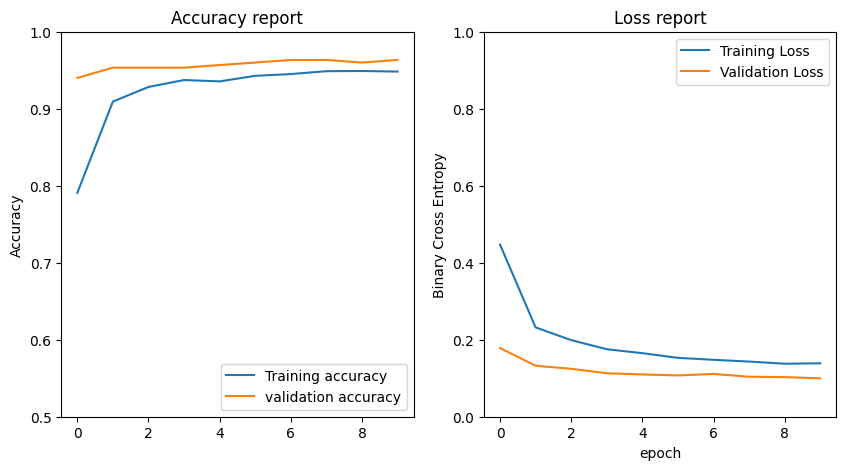

In [53]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(10, 5))

plt.subplot(121)
plt.plot(acc, label='Training accuracy')
plt.plot(val_acc, label='validation accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1.0])
plt.title('Accuracy report')

plt.subplot(122)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Binary Cross Entropy')
plt.ylim([0, 1.0])
plt.title('Loss report')
plt.xlabel('epoch')

plt.show()

Fine tuning

In [55]:
base_model.trainable = True

print('Number of layers in base model:', len(base_model.layers))

Number of layers in base model: 154


In [24]:
fine_tune_from = 134

for layer in base_model.layers[:fine_tune_from]:
  layer.trainable = False

In [56]:
opt = tf.keras.optimizers.Adam(learning_rate=base_lr / 10)
model.compile(optimizer=opt, loss=tf.keras.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [57]:
total_epoch = base_epoch + 10

history_fine = model.fit(train_dataset, epochs=total_epoch, initial_epoch=base_epoch, validation_data=valid_dataset, callbacks=[early_stopping, checkpoint])

Epoch 11/20
63/63 [==============================] - 12s 118ms/step - loss: 0.1512 - accuracy: 0.9419 - val_loss: 0.0759 - val_accuracy: 0.9667
Epoch 12/20
63/63 [==============================] - 7s 99ms/step - loss: 0.0935 - accuracy: 0.9715 - val_loss: 0.0705 - val_accuracy: 0.9767
Epoch 13/20
63/63 [==============================] - 7s 100ms/step - loss: 0.0962 - accuracy: 0.9654 - val_loss: 0.0457 - val_accuracy: 0.9800
Epoch 14/20
63/63 [==============================] - 7s 99ms/step - loss: 0.0699 - accuracy: 0.9753 - val_loss: 0.0687 - val_accuracy: 0.9700
Epoch 15/20
63/63 [==============================] - 7s 100ms/step - loss: 0.0550 - accuracy: 0.9807 - val_loss: 0.1212 - val_accuracy: 0.9567
Epoch 16/20
63/63 [==============================] - 7s 101ms/step - loss: 0.0639 - accuracy: 0.9804 - val_loss: 0.0301 - val_accuracy: 0.9867
Epoch 17/20
63/63 [==============================] - 7s 100ms/step - loss: 0.0499 - accuracy: 0.9846 - val_loss: 0.0450 - val_accuracy: 0.9867


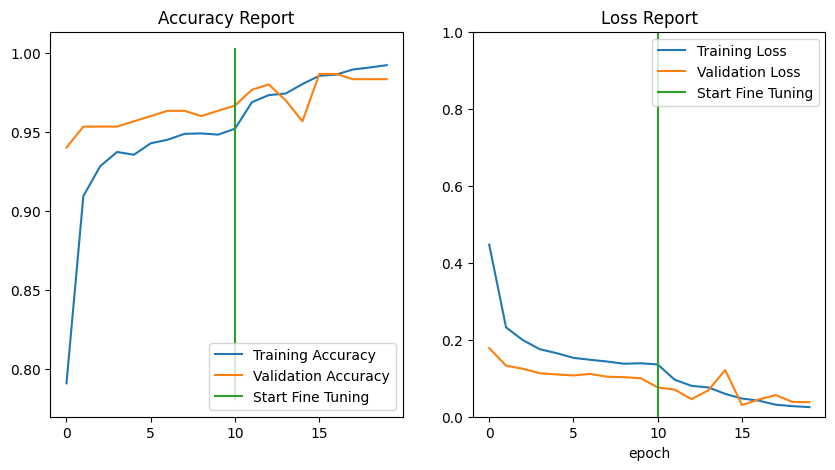

In [58]:
new_acc = acc + history_fine.history['accuracy']
new_val_acc = val_acc + history_fine.history['val_accuracy']

new_loss = loss + history_fine.history['loss']
new_val_loss = val_loss + history_fine.history['val_loss']

plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.plot(new_acc, label='Training Accuracy')
plt.plot(new_val_acc, label='Validation Accuracy')
plt.plot([base_epoch,base_epoch], plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Accuracy Report')

plt.subplot(122)
plt.plot(new_loss, label='Training Loss')
plt.plot(new_val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([base_epoch,base_epoch], plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Loss Report')
plt.xlabel('epoch')

plt.show()

In [60]:
model.load_weights('beauty_ckpt.h5')

In [61]:
model.evaluate(test_dataset)

5/5 [==============================] - 0s 23ms/step - loss: 0.0109 - accuracy: 0.9967


[0.010947988368570805, 0.996666669845581]

In [62]:
model.save('beauty_1.h5')